In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops

In [2]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                  'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x) >= 1]
               for y in housing_file.text.split('\n') if len(y) >= 1]

y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i, x in enumerate(y) if housing_header[i] in cols_used]
                  for y in housing_data])
x_vals = (x_vals - x_vals.min(0) / x_vals.ptp(0))

np.random.seed(13)
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8),
                                replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [20]:
ops.reset_default_graph()
with tf.Session() as sess:
    k = 4
    bs = len(x_vals_test)
    
    x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
    x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
    y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    
    distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train,
                                                tf.expand_dims(x_data_test, 1))), axis=2)
    top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
    x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1), 1)
    x_sums_repeated = tf.matmul(x_sums, tf.ones([1, k], tf.float32))
    x_val_weights = tf.expand_dims(tf.div(top_k_xvals, x_sums_repeated), 1)
    
    top_k_yvals = tf.gather(y_target_train, top_k_indices)
    prediction = tf.squeeze(tf.matmul(x_val_weights, top_k_yvals), axis=1)
    
    mse = tf.div(tf.reduce_sum(tf.square(
                 tf.subtract(prediction, y_target_test))), bs)
    num_loops = int(np.ceil(len(x_vals_test) / bs))
    
    for i in range(num_loops):
        min_index = i * bs
        max_index = min((i + 1) * bs, len(x_vals_train))
        x_batch = x_vals_test[min_index:max_index]
        y_batch = y_vals_test[min_index:max_index]
        predictions = sess.run(prediction, feed_dict={
            x_data_train: x_vals_train,
            x_data_test: x_batch,
            y_target_train: y_vals_train,
            y_target_test: y_batch,
        })
        batch_mse = sess.run(mse, feed_dict={
            x_data_train: x_vals_train,
            x_data_test: x_batch,
            y_target_train: y_vals_train,
            y_target_test: y_batch,
        })
        print('Batch #' + str(i + 1) + ' MSE: ' + str(np.round(batch_mse, 3)))

Batch #1 MSE: 49.381


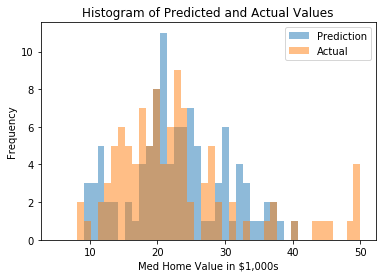

In [21]:
bins = np.linspace(5, 50, 45)
plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()